In [18]:
%load_ext autoreload
%autoreload 2

import os

print("original dir: ", os.getcwd())

if os.getcwd().endswith("NewMethod"):
    new_path = "../"
    os.chdir(new_path)
    print("changed dir: ", os.getcwd())
    
import torch
import torch.nn
from torch import optim
from torch.nn import CrossEntropyLoss
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from tqdm import tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
original dir:  f:\MyCourse(5 delayed 1)\erasure code\SUSTech-Coded-Computation\src


In [2]:
import datetime

TASK_CONFIG = {
    "TASK": "CIFAR10",
    "DATE": datetime.datetime.now().strftime("%Y_%m_%d"),
    "MODEL": "LeNet9",
}

读取数据集

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 设置数据转换
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# 设置数据集（训练集与测试集合）

"""
MNIST:
image: (1, 28, 28), label: (0-9)

FashionMNIST:
image: (1, 28, 28), label: (0-9)

CIFAR10:
image: (3, 32, 32), label: (0-9)
"""

print(f"当前任务为 {TASK_CONFIG['TASK']}")
train_dataset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform,
)
test_dataset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform,
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Data is ready!")

当前任务为 CIFAR10
Files already downloaded and verified
Files already downloaded and verified
Data is ready!


设置部分参数

In [47]:
K = 4
R = 2
N = K + R
original_data_shape = tuple(train_dataset[0][0].shape)
num_classes = 10
print(f"K: {K}")
print(f"R: {R}")
print(f"N: {N}")
print(f"data_shape: {original_data_shape}")
print(f"num_classes: {num_classes}")

K: 4
R: 2
N: 6
data_shape: (3, 32, 32)
num_classes: 10


定义 base model

In [5]:
import torch

from base_model.MyModel1 import MyModel1
from base_model.LeNet5 import LeNet5
from base_model.LeNet9 import LeNet9

# 引入 base model, 该model将在后续全部过程中使用
# ResNet
assert TASK_CONFIG["MODEL"] == "LeNet9"
model = LeNet9(input_dim=original_data_shape, num_classes=num_classes)

fc_input_size: 4096


In [25]:
# 读取模型
base_model_path = (
    f"./base_model/{TASK_CONFIG['MODEL']}/{TASK_CONFIG['TASK']}/model.pth"
)
print(f"base_model_path: {base_model_path}")

model.load_state_dict(torch.load(base_model_path, map_location=device))
conv_segment = model.get_conv_segment()
fc_segment = model.get_fc_segment()
model.to(device)
model.eval()

print("Model is ready!")

base_model_path: ./base_model/LeNet9/CIFAR10/model.pth
Model is ready!


验证 base model 准确率

In [48]:
# 测试循环
model.eval()  # 设置模型为评估模式

correct = 0
total = 0
with torch.no_grad():  # 在评估过程中不计算梯度
    for data, target in train_loader:
        # 将数据移动到设备上
        data, target = data.to(device), target.to(device)

        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f"训练集-> 总量: {total}, 正确数量: {correct}, 准确率: {100 * correct / total}%")

correct = 0
total = 0
with torch.no_grad():  # 在评估过程中不计算梯度
    for data, target in test_loader:
        # 将数据移动到设备上
        data, target = data.to(device), target.to(device)

        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f"测试集-> 总量: {total}, 正确数量: {correct}, 准确率: {100 * correct / total}%")

训练集-> 总量: 50000, 正确数量: 43124, 准确率: 86.248%
测试集-> 总量: 10000, 正确数量: 7432, 准确率: 74.32%


验证 model 和 conv_segment, fc_segment 的输出是否一致

In [49]:
x = torch.randn(1, *original_data_shape).to(device)
model.to(device)
y = model(x)
print(y.data)

z = conv_segment(x)
z = z.flatten(1)
z = fc_segment(z)
print(z.data)
print(torch.allclose(y, z))

tensor([[ 0.9263,  1.1661, -2.5750, -3.4881, -3.6475, -5.0416, -0.3305, -5.9655,
          3.1479, -2.0112]], device='cuda:0')
tensor([[ 0.9263,  1.1661, -2.5750, -3.4881, -3.6475, -5.0416, -0.3305, -5.9655,
          3.1479, -2.0112]], device='cuda:0')
True


设置另一部分参数

In [50]:
from util.util import cal_input_shape


conv_output_shape = model.calculate_conv_output(input_dim=original_data_shape)
print(f"conv_output_shape: {conv_output_shape}")
assert conv_output_shape[2] % K == 0

split_conv_output_shape = (
    conv_output_shape[0],
    conv_output_shape[1],
    conv_output_shape[2] // K,
)
print(f"split_conv_output_shape: {split_conv_output_shape}")

conv_segment.to('cpu')
conv_segment.train()
split_data_range = cal_input_shape(
    model=conv_segment,
    original_input_shape=original_data_shape,
    original_output_shape=conv_output_shape,
    split_num=K,
)
print(f"split_data_range: {split_data_range}")

# print(conv_segment)
print(
    f"split_conv_output_data_shape from split_data_shape: {[tuple(conv_segment(torch.randn(1, _[0], _[1], _[3] - _[2])).shape) for _ in split_data_range]}"
)

split_data_shapes = [
    (
        _[0],
        _[1],
        _[3] - _[2],
    )
    for _ in split_data_range
]
print(f"split_data_shapes: {split_data_shapes}")

split_data_shape = split_data_shapes[0]
print(f"choose the first one as the split_data_shape: {split_data_shape}")

conv_output_shape: (256, 4, 4)
split_conv_output_shape: (256, 4, 1)
split_data_range: [(3, 32, 0, 23), (3, 32, 4, 27), (3, 32, 8, 31), (3, 32, 12, 32)]
split_conv_output_data_shape from split_data_shape: [(1, 256, 4, 1), (1, 256, 4, 1), (1, 256, 4, 1), (1, 256, 4, 1)]
split_data_shapes: [(3, 32, 23), (3, 32, 23), (3, 32, 23), (3, 32, 20)]
choose the first one as the split_data_shape: (3, 32, 23)


验证分割后的输入，能够恰好恢复出原始输出

In [51]:
x = torch.randn(1, *original_data_shape).to(device)
conv_segment.to(device)
y = conv_segment(x)
print(f"y.shape: {y.shape}")

x_split = [x[:, :, :, _[2]:_[3]] for _ in split_data_range]
y_split = [conv_segment(_x) for _x in x_split]
print(f"y_split.shape: {[tuple(_y.shape) for _y in y_split]}")

y_hat = torch.cat(y_split, dim=3)
print(f"y_hat.shape: {y_hat.shape}")

# |A-B| <= atol + rtol * |B|
print(f"y和y_hat是否相等: {torch.allclose(y_hat, y, rtol=1e-08, atol=1e-05)}")

diff = torch.abs(y_hat - y)
epsilon = 0.0001
print(f"y和y_hat是否相等: {torch.all(diff <= epsilon)}")
# print(torch.allclose(y_split[0], y[:, :, :, 0:5]))
# print(torch.allclose(y_split[1], y[:, :, :, 5:10]))
# print(torch.allclose(y_split[2], y[:, :, :, 10:15]))
# print(torch.allclose(y_split[3], y[:, :, :, 15:20]))

# print(y[0][0][0] == y_hat[0][0][0])
# print(y[0][0][0])
# print(y_hat[0][0][0])
# y = x
# y_split = x_split
# for layer in conv_segment:
#     print(layer)
#     y = layer(y)
#     y_split = [layer(_y) for _y in y_split]
#     print(f"y.shape: {y.shape}")
#     print(f"y_split.shape: {[tuple(_.shape) for _ in y_split]}")
#     print(y[0][0][0])
#     print(y_split[0][0][0][0])
#     print(y_split[1][0][0][0])
#     print(y_split[2][0][0][0])
#     print(y_split[3][0][0][0])

y.shape: torch.Size([1, 256, 4, 4])
y_split.shape: [(1, 256, 4, 1), (1, 256, 4, 1), (1, 256, 4, 1), (1, 256, 4, 1)]
y_hat.shape: torch.Size([1, 256, 4, 4])
y和y_hat是否相等: True
y和y_hat是否相等: True


定义 Encoder Decoder

In [52]:
from encoder.mlp_encoder import MLPEncoder
from encoder.conv_encoder import CatChannelConvEncoder, CatBatchSizeConvEncoder
from decoder.mlp_decoder import MLPDecoder
from decoder.conv_decoder import CatChannelConvDecoder, CatBatchSizeConvDecoder

print(f"split_data_shape: {split_data_shape}")
print(f"split_conv_output_shape: {split_conv_output_shape}")

encoder = MLPEncoder(num_in=K, num_out=R, in_dim=split_data_shape)
decoder = MLPDecoder(num_in=N, num_out=K, in_dim=split_conv_output_shape)

# encoder = CatChannelConvEncoder(num_in=K, num_out=R, in_dim=split_data_shape)
# decoder = CatChannelConvDecoder(
#     num_in=N, num_out=K, in_dim=split_conv_output_shape
# )

# encoder = CatBatchSizeConvEncoder(num_in=K, num_out=R, in_dim=split_data_shape)
# decoder = CatBatchSizeConvDecoder(num_in=N, num_out=K, in_dim=split_conv_output_data_shape)

split_data_shape: (3, 32, 23)
split_conv_output_shape: (256, 4, 1)


In [12]:
# print(torch.cuda.memory_summary())

In [53]:
def getModelSize(model):
    param_size = 0
    param_sum = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
        param_sum += param.nelement()
    buffer_size = 0
    buffer_sum = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
        buffer_sum += buffer.nelement()
    all_size = (param_size + buffer_size) / 1024 / 1024
    print("模型总大小为：{:.3f}MB".format(all_size))
    return (param_size, param_sum, buffer_size, buffer_sum, all_size)

getModelSize(encoder)
getModelSize(decoder)
print()

模型总大小为：446.394MB
模型总大小为：224.047MB



训练 Encoder Decoder

In [54]:
epoch_num = 10
print(f"epoch_num: {epoch_num}")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm

print(f"Train dataset: {len(train_dataset)}")
print("image size: ", train_dataset[0][0].size())

# 定义损失函数
criterion = nn.MSELoss()

# optimizer_encoder = optim.SGD(encoder.parameters(), lr=1e-3, momentum=0.8, weight_decay=1e-5)
# optimizer_decoder = optim.SGD(decoder.parameters(), lr=1e-3, momentum=0.8, weight_decay=1e-5)

optimizer_encoder = optim.Adam(encoder.parameters(), lr=1e-4, weight_decay=1e-6)
optimizer_decoder = optim.Adam(decoder.parameters(), lr=1e-4, weight_decay=1e-6)

model.to(device)
conv_segment.to(device)
fc_segment.to(device)
encoder.to(device)
decoder.to(device)

model.eval()
conv_segment.eval()
fc_segment.eval()
encoder.train()
decoder.train()

model.eval()
for m in model.modules():
    if isinstance(m, nn.BatchNorm2d):
        m.track_running_stats = False

loss_list = [[] for _ in range(epoch_num)]

for epoch in range(epoch_num):
    train_loader_tqdm = tqdm(
        train_loader,
        desc=f"Epoch {epoch+1}/{epoch_num}",
        bar_format="{l_bar}{bar:20}{r_bar}",
    )
    correct = 0
    correct_truth = 0
    total = 0
    for images, labels in train_loader_tqdm:
        images = images.to(device)
        labels = labels.to(device)

        # split image tensor(64, 3, 32, 32) -> [tensor(64, 3, 32, 8) * K]
        images_list = []
        for _1, _2, start, end in split_data_range:
            images_list.append(images[:, :, :, start:end].clone())

        pad = (0, 3, 0, 0)
        images_list[-1] = F.pad(images_list[-1], pad, "constant", value=0)

        ground_truth = conv_segment(images)
        ground_truth = ground_truth.view(ground_truth.size(0), -1)

        # forward
        images_list += encoder(images_list)
        output_list = []
        for i in range(N):
            output = conv_segment(images_list[i])
            output_list.append(output)
        # losed_output_list = lose_something(output_list, self.lose_device_index)
        decoded_output_list = decoder(output_list)
        output = torch.cat(decoded_output_list, dim=3)
        output = output.view(output.size(0), -1)

        loss = criterion(output, ground_truth)

        loss_list[epoch].append(loss.item())

        # backward
        optimizer_encoder.zero_grad()
        optimizer_decoder.zero_grad()
        loss.backward()
        optimizer_encoder.step()
        optimizer_decoder.step()

        # calculate accuracy
        _, predicted = torch.max(fc_segment(output).data, 1)
        _, predicted_truth = torch.max(fc_segment(ground_truth.data), 1)
        # print(predicted)
        # print(predicted_truth)
        # print(labels)
        correct += (predicted == labels).sum().item()
        correct_truth += (predicted_truth == labels).sum().item()
        total += labels.size(0)

        train_loader_tqdm.set_postfix(loss=loss.item())

    print(f"Original Accuracy: {100 * correct_truth / total}%, Train Accuracy: {100 * correct / total}%")


epoch_num: 10
Train dataset: 50000
image size:  torch.Size([3, 32, 32])


Epoch 1/10: 100%|████████████████████| 391/391 [04:33<00:00,  1.43it/s, loss=0.0114]


Original Accuracy: 86.248%, Train Accuracy: 72.174%


Epoch 2/10: 100%|████████████████████| 391/391 [04:32<00:00,  1.43it/s, loss=0.00697]


Original Accuracy: 86.248%, Train Accuracy: 82.212%


Epoch 3/10: 100%|████████████████████| 391/391 [02:58<00:00,  2.19it/s, loss=0.00564]


Original Accuracy: 86.248%, Train Accuracy: 83.524%


Epoch 4/10: 100%|████████████████████| 391/391 [02:58<00:00,  2.19it/s, loss=0.0045] 


Original Accuracy: 86.248%, Train Accuracy: 84.144%


Epoch 5/10: 100%|████████████████████| 391/391 [02:58<00:00,  2.19it/s, loss=0.00372]


Original Accuracy: 86.248%, Train Accuracy: 84.552%


Epoch 6/10: 100%|████████████████████| 391/391 [02:58<00:00,  2.18it/s, loss=0.00301]


Original Accuracy: 86.248%, Train Accuracy: 84.878%


Epoch 7/10: 100%|████████████████████| 391/391 [02:59<00:00,  2.18it/s, loss=0.00238]


Original Accuracy: 86.248%, Train Accuracy: 85.016%


Epoch 8/10: 100%|████████████████████| 391/391 [02:59<00:00,  2.18it/s, loss=0.00241]


Original Accuracy: 86.248%, Train Accuracy: 85.152%


Epoch 9/10: 100%|████████████████████| 391/391 [02:59<00:00,  2.18it/s, loss=0.00199]


Original Accuracy: 86.248%, Train Accuracy: 85.268%


Epoch 10/10: 100%|████████████████████| 391/391 [02:59<00:00,  2.18it/s, loss=0.00175]

Original Accuracy: 86.248%, Train Accuracy: 85.292%


保存模型

In [ ]:
# save_dir = f"./save/{TASK_CONFIG['TASK']}/{TASK_CONFIG['MODEL']}/{TASK_CONFIG['DATE']}/K{K}-R{R}-mlp/"
# encoder_path = (
#     save_dir
#     + f"encoder-task_{TASK_CONFIG['TASK']}-basemodel_{TASK_CONFIG['MODEL']}-K{K}-R{R}.pth"
# )
# decoder_path = (
#     save_dir
#     + f"decoder-task_{TASK_CONFIG['TASK']}-basemodel_{TASK_CONFIG['MODEL']}-K{K}-R{R}.pth"
# )

# print(f"save_dir: {save_dir}")
# print(f"encoder_path: {encoder_path}")
# print(f"decoder_path: {decoder_path}")

In [150]:
# import os


# os.makedirs(os.path.dirname(encoder_path), exist_ok=True)
# os.makedirs(os.path.dirname(decoder_path), exist_ok=True)

# torch.save(encoder.state_dict(), encoder_path)
# torch.save(decoder.state_dict(), decoder_path)

In [151]:
# print(*loss_list)

# path = save_dir + "loss.txt"
# os.makedirs(os.path.dirname(path), exist_ok=True)
# with open(path, "w") as f:
#     for loss in loss_list:
#         f.write(" ".join(map(str, loss)) + "\n")

[3.15645170211792, 3.5783889293670654, 3.4615845680236816, 3.2651615142822266, 3.3844847679138184, 3.400930166244507, 3.469923973083496, 3.4889750480651855, 3.4052398204803467, 3.526693820953369, 3.149873733520508, 3.3822202682495117, 3.279466152191162, 2.941798210144043, 2.9943928718566895, 2.6153135299682617, 2.8076605796813965, 2.6839263439178467, 2.3214685916900635, 2.0366711616516113, 2.192711353302002, 2.1291747093200684, 2.0355453491210938, 2.0535764694213867, 2.218278169631958, 2.18638014793396, 2.0462303161621094, 1.8303728103637695, 1.8381712436676025, 2.087784767150879, 1.8634135723114014, 1.8777048587799072, 1.86776602268219, 1.8552325963974, 1.8781282901763916, 1.7746882438659668, 2.0732712745666504, 1.8667384386062622, 1.9151195287704468, 1.7484238147735596, 1.9499928951263428, 1.7592861652374268, 1.6632952690124512, 1.7229059934616089, 1.7498080730438232, 1.755472183227539, 1.5873022079467773, 1.8233590126037598, 1.7944351434707642, 1.6369528770446777, 1.6938941478729248

In [ ]:
# import os

# with open("loss.txt", "r") as f:
#     loss_list = [list(map(float, line.split())) for line in f.readlines()]

In [43]:
# print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


记录的loss数量: 5740
最后一个loss: 0.15112215280532837


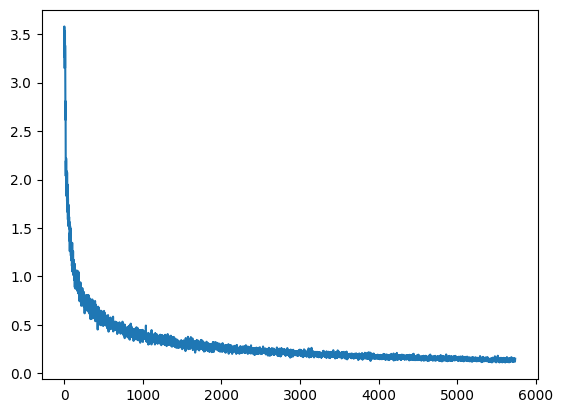

In [152]:
# import matplotlib.pyplot as plt
# plt.style.use("default")

# y = [e for l in loss_list for e in l]
# print(f"记录的loss数量: {len(y)}")
# print(f"最后一个loss: {y[-1]}")

# plt.figure()
# plt.plot(y)
# plt.show()

Evaluation

In [42]:
def lose_something(output_list, lose_num):
    if lose_num == 0:
        return output_list
    
    lose_index = torch.randperm(len(output_list))[:lose_num]
    losed_output_list = []

    for i in range(len(output_list)):

        if i in lose_index:

            losed_output_list.append(torch.zeros_like(output_list[i]))
        else:

            losed_output_list.append(output_list[i])
    return losed_output_list

In [43]:
import torch

from tqdm import tqdm

from dataset.image_dataset import ImageDataset
from util.split_data import split_vector

conv_segment.to(device)
fc_segment.to(device)
model.to(device)
encoder.to(device)
decoder.to(device)

conv_segment.eval()
fc_segment.eval()
model.eval()
encoder.eval()
decoder.eval()

def evaluation(loader, loss_num):
    original_correct = 0
    merge_correct = 0
    correct = 0
    total = 0
    with torch.no_grad():
        loader_tqdm = tqdm(
            loader,
            desc=f"Evaluating...",
            bar_format="{l_bar}{bar:20}{r_bar}",
        )
        for images, labels in loader_tqdm:
            images = images.to(device)
            labels = labels.to(device)
            
            # split image tensor(64, 3, 32, 32) -> [tensor(64, 3, 32, 8) * K]
            images_list = []
            for _1, _2, start, end in split_data_range:
                images_list.append(images[:, :, :, start:end].clone())
        
            pad = (0, 3, 0, 0)
            images_list[-1] = F.pad(images_list[-1], pad, "constant", value=0)

            _, predicted = torch.max(model(images).data, 1)
            original_correct += (predicted == labels).sum().item()

            output = conv_segment(images)
            output = output.view(output.size(0), -1)
            output = fc_segment(output)
            _, predicted = torch.max(output.data, 1)
            merge_correct += (predicted == labels).sum().item()

            imageDataset_list = [
                ImageDataset(images) for images in images_list + encoder(images_list)
            ]
            output_list = []
            for i in range(N):
                imageDataset = imageDataset_list[i]
                output = conv_segment(imageDataset.images)
                output_list.append(output)
            losed_output_list = lose_something(output_list, loss_num)
            decoded_output_list = decoder(losed_output_list)
            output = torch.cat(decoded_output_list, dim=3)
            output = output.view(output.size(0), -1)

            _, predicted = torch.max(fc_segment(output).data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    print(f"样本总数: {total}")
    print(
        f"原始模型(model) -> 预测正确数: {original_correct}, 预测准确率: {(100 * original_correct / total):.2f}%"
    )
    print(
        f"原始模型(conv+fc) -> 预测正确数: {merge_correct}, 预测准确率: {(100 * merge_correct / total):.2f}%"
    )
    print(
        f"使用Encoder和Decoder -> 预测正确数: {correct}, 预测准确率: {(100 * correct / total):.2f}%"
    )

In [55]:
# 训练集
for i in range(N + 1):
    print(f"loss_num: {i}")
    evaluation(train_loader, i)


loss_num: 0


Evaluating...: 100%|████████████████████| 391/391 [01:04<00:00,  6.07it/s]


样本总数: 50000
原始模型(model) -> 预测正确数: 43124, 预测准确率: 86.25%
原始模型(conv+fc) -> 预测正确数: 43124, 预测准确率: 86.25%
使用Encoder和Decoder -> 预测正确数: 42754, 预测准确率: 85.51%
loss_num: 1


Evaluating...: 100%|████████████████████| 391/391 [01:04<00:00,  6.09it/s]


样本总数: 50000
原始模型(model) -> 预测正确数: 43124, 预测准确率: 86.25%
原始模型(conv+fc) -> 预测正确数: 43124, 预测准确率: 86.25%
使用Encoder和Decoder -> 预测正确数: 40041, 预测准确率: 80.08%
loss_num: 2


Evaluating...: 100%|████████████████████| 391/391 [01:04<00:00,  6.05it/s]


样本总数: 50000
原始模型(model) -> 预测正确数: 43124, 预测准确率: 86.25%
原始模型(conv+fc) -> 预测正确数: 43124, 预测准确率: 86.25%
使用Encoder和Decoder -> 预测正确数: 36959, 预测准确率: 73.92%
loss_num: 3


Evaluating...: 100%|████████████████████| 391/391 [01:04<00:00,  6.05it/s]


样本总数: 50000
原始模型(model) -> 预测正确数: 43124, 预测准确率: 86.25%
原始模型(conv+fc) -> 预测正确数: 43124, 预测准确率: 86.25%
使用Encoder和Decoder -> 预测正确数: 32682, 预测准确率: 65.36%
loss_num: 4


Evaluating...: 100%|████████████████████| 391/391 [01:04<00:00,  6.03it/s]


样本总数: 50000
原始模型(model) -> 预测正确数: 43124, 预测准确率: 86.25%
原始模型(conv+fc) -> 预测正确数: 43124, 预测准确率: 86.25%
使用Encoder和Decoder -> 预测正确数: 26940, 预测准确率: 53.88%
loss_num: 5


Evaluating...: 100%|████████████████████| 391/391 [01:04<00:00,  6.04it/s]


样本总数: 50000
原始模型(model) -> 预测正确数: 43124, 预测准确率: 86.25%
原始模型(conv+fc) -> 预测正确数: 43124, 预测准确率: 86.25%
使用Encoder和Decoder -> 预测正确数: 18217, 预测准确率: 36.43%
loss_num: 6


Evaluating...: 100%|████████████████████| 391/391 [01:04<00:00,  6.05it/s]

样本总数: 50000
原始模型(model) -> 预测正确数: 43124, 预测准确率: 86.25%
原始模型(conv+fc) -> 预测正确数: 43124, 预测准确率: 86.25%
使用Encoder和Decoder -> 预测正确数: 5000, 预测准确率: 10.00%


In [56]:
# 测试集
for i in range(N + 1):
    print(f"loss_num: {i}")
    evaluation(test_loader, i)

loss_num: 0


Evaluating...: 100%|████████████████████| 157/157 [00:13<00:00, 11.90it/s]


样本总数: 10000
原始模型(model) -> 预测正确数: 7432, 预测准确率: 74.32%
原始模型(conv+fc) -> 预测正确数: 7432, 预测准确率: 74.32%
使用Encoder和Decoder -> 预测正确数: 7439, 预测准确率: 74.39%
loss_num: 1


Evaluating...: 100%|████████████████████| 157/157 [00:13<00:00, 11.71it/s]


样本总数: 10000
原始模型(model) -> 预测正确数: 7432, 预测准确率: 74.32%
原始模型(conv+fc) -> 预测正确数: 7432, 预测准确率: 74.32%
使用Encoder和Decoder -> 预测正确数: 7129, 预测准确率: 71.29%
loss_num: 2


Evaluating...: 100%|████████████████████| 157/157 [00:13<00:00, 11.65it/s]


样本总数: 10000
原始模型(model) -> 预测正确数: 7432, 预测准确率: 74.32%
原始模型(conv+fc) -> 预测正确数: 7432, 预测准确率: 74.32%
使用Encoder和Decoder -> 预测正确数: 6631, 预测准确率: 66.31%
loss_num: 3


Evaluating...: 100%|████████████████████| 157/157 [00:13<00:00, 11.62it/s]


样本总数: 10000
原始模型(model) -> 预测正确数: 7432, 预测准确率: 74.32%
原始模型(conv+fc) -> 预测正确数: 7432, 预测准确率: 74.32%
使用Encoder和Decoder -> 预测正确数: 6055, 预测准确率: 60.55%
loss_num: 4


Evaluating...: 100%|████████████████████| 157/157 [00:13<00:00, 11.68it/s]


样本总数: 10000
原始模型(model) -> 预测正确数: 7432, 预测准确率: 74.32%
原始模型(conv+fc) -> 预测正确数: 7432, 预测准确率: 74.32%
使用Encoder和Decoder -> 预测正确数: 5064, 预测准确率: 50.64%
loss_num: 5


Evaluating...: 100%|████████████████████| 157/157 [00:13<00:00, 11.74it/s]


样本总数: 10000
原始模型(model) -> 预测正确数: 7432, 预测准确率: 74.32%
原始模型(conv+fc) -> 预测正确数: 7432, 预测准确率: 74.32%
使用Encoder和Decoder -> 预测正确数: 3385, 预测准确率: 33.85%
loss_num: 6


Evaluating...: 100%|████████████████████| 157/157 [00:13<00:00, 11.75it/s]

样本总数: 10000
原始模型(model) -> 预测正确数: 7432, 预测准确率: 74.32%
原始模型(conv+fc) -> 预测正确数: 7432, 预测准确率: 74.32%
使用Encoder和Decoder -> 预测正确数: 1000, 预测准确率: 10.00%


In [ ]:
# 加载模型
# encoder = MLPEncoder(num_in=K, num_out=R, in_dim=split_data_shape)
# decoder = MLPDecoder(num_in=N, num_out=K, in_dim=split_conv_output_shape)

# encoder.load_state_dict(torch.load(encoder_path))
# decoder.load_state_dict(torch.load(decoder_path))

训练 base model

In [6]:
#!! 专门针对CIFAR10数据集的数据增强和预处理

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 设置数据增强和预处理
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # 对图像进行随机裁剪，裁剪后图像大小为32x32，边缘填充4个像素
    transforms.RandomHorizontalFlip(),    # 50%的概率水平翻转图像
    transforms.RandomRotation(15),        # 随机旋转图像±15度
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # 随机调整亮度、对比度、饱和度和色调
    transforms.ToTensor(),                # 将图片转换为Tensor，并归一化到[0,1]
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # 标准化处理，使用CIFAR-10数据集的均值和标准差
])

# 测试集通常不应用太多变换，通常只进行标准化处理
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 创建数据加载器
base_model_trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
base_model_testloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# 现在可以使用trainloader和testloader在你的模型中进行训练和测试了


In [7]:
# 训练函数
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    tqdm_train_loader = tqdm(train_loader, desc=f"Train Epoch {epoch}")
    for idx, (data, target) in enumerate(tqdm_train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        tqdm_train_loader.set_postfix(loss=loss.item())
    train_loss /= idx + 1
    print(f"Train set: Average loss: {train_loss:.4f}, Accuracy: {(100 * correct / len(train_loader.dataset)):.2f}%")
    print('-'*50)


In [8]:
# 测试函数
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        tqdm_test_loader = tqdm(test_loader, desc="Test")
        for idx, (data, target) in enumerate(tqdm_test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= idx + 1
    print(f"Test set: Average loss: {test_loss:.4f}, Accuracy: {(100 * correct / len(test_loader.dataset)):.2f}%")
    print('-'*50 + '\n')
    

In [20]:
BASE_MODEL_NUM_EPOCHS = 2
BASE_MODEL_LR = 1e-3
# BASE_MODEL_MOMENTUM = 0.8
BASE_MODEL_WEIGHT_DECAY = 1e-5
# BASE_MODEL_CLIP_NORM = 1.0

In [22]:
optimizer = optim.Adam(model.parameters(), lr=BASE_MODEL_LR, weight_decay=BASE_MODEL_WEIGHT_DECAY)
# optimizer = optim.SGD(model.parameters(), lr=BASE_MODEL_LR, momentum=BASE_MODEL_MOMENTUM, weight_decay=BASE_MODEL_WEIGHT_DECAY)

criterion = CrossEntropyLoss()

model.to(device)
for epoch in range(BASE_MODEL_NUM_EPOCHS):
    train(model, device, base_model_trainloader, optimizer, epoch)
    test(model, device, base_model_testloader)

Train Epoch 0: 100%|██████████| 391/391 [00:33<00:00, 11.58it/s, loss=0.726]


Train set: Average loss: 0.5888, Accuracy: 79.11%
--------------------------------------------------


Test: 100%|██████████| 157/157 [00:08<00:00, 18.55it/s]


Test set: Average loss: 0.7775, Accuracy: 73.44%
--------------------------------------------------



Train Epoch 1: 100%|██████████| 391/391 [00:32<00:00, 12.01it/s, loss=0.564]


Train set: Average loss: 0.5129, Accuracy: 81.72%
--------------------------------------------------


Test: 100%|██████████| 157/157 [00:08<00:00, 18.23it/s]

Test set: Average loss: 0.7666, Accuracy: 74.32%
--------------------------------------------------



In [23]:
# Evaluation Process
# 测试循环
model.eval()  # 设置模型为评估模式

print("Train dataset:")

correct = 0
total = 0
with torch.no_grad():  # 在评估过程中不计算梯度
    for data, target in base_model_trainloader:
        # 将数据移动到设备上
        data, target = data.to(device), target.to(device)

        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f"训练集-> 总量: {total}, 正确数量: {correct}, 准确率: {100 * correct / total}%")

print("Test dataset:")

correct = 0
total = 0
with torch.no_grad():  # 在评估过程中不计算梯度
    for data, target in base_model_testloader:
        # 将数据移动到设备上
        data, target = data.to(device), target.to(device)

        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f"测试集-> 总量: {total}, 正确数量: {correct}, 准确率: {100 * correct / total}%")


Train dataset:
训练集-> 总量: 50000, 正确数量: 43124, 准确率: 86.248%
Test dataset:
测试集-> 总量: 10000, 正确数量: 7432, 准确率: 74.32%


In [24]:
# 保存模型
now = datetime.datetime.now()
filepath = f"base_model/{TASK_CONFIG['MODEL']}/{TASK_CONFIG['TASK']}/model.pth"
dirpath = os.path.dirname(filepath)
if not os.path.exists(dirpath):
    os.makedirs(dirpath)
torch.save(model.state_dict(), filepath)

In [ ]:
# 读取模型
# model = LeNet5(input_dim=(1, 28, 28), num_classes=10)
# model.load_state_dict(torch.load(filepath))

In [92]:
# CIFAR_10 is the model for cifar-10 from GPT

# from torch.nn import CrossEntropyLoss
# import torch.optim as optim
# from base_model.CIFAR10_CNN import CIFAR10_CNN

# test_model = CIFAR10_CNN().to(device)
# optimizer = optim.Adam(test_model.parameters(), lr=0.001)
# criterion = CrossEntropyLoss()

# for epoch in range(10):
#     train(test_model, device, base_model_trainloader, optimizer, epoch)
#     test(test_model, device, base_model_testloader)

Train Epoch 0: 100%|██████████| 391/391 [00:44<00:00,  8.84it/s, loss=1.4] 


Train set: Average loss: 1.7057, Accuracy: 35.49%
--------------------------------------------------


Test: 100%|██████████| 157/157 [00:15<00:00, 10.29it/s]


Test set: Average loss: 1.3033, Accuracy: 51.39%
--------------------------------------------------



Train Epoch 1: 100%|██████████| 391/391 [00:34<00:00, 11.49it/s, loss=0.991]


Train set: Average loss: 1.1765, Accuracy: 57.29%
--------------------------------------------------


Test: 100%|██████████| 157/157 [00:14<00:00, 10.56it/s]


Test set: Average loss: 0.9887, Accuracy: 65.25%
--------------------------------------------------



Train Epoch 2: 100%|██████████| 391/391 [00:35<00:00, 11.08it/s, loss=0.731]


Train set: Average loss: 0.9172, Accuracy: 67.62%
--------------------------------------------------


Test: 100%|██████████| 157/157 [00:15<00:00, 10.16it/s]


Test set: Average loss: 0.8411, Accuracy: 71.01%
--------------------------------------------------



Train Epoch 3: 100%|██████████| 391/391 [00:34<00:00, 11.43it/s, loss=0.731]


Train set: Average loss: 0.7712, Accuracy: 73.15%
--------------------------------------------------


Test: 100%|██████████| 157/157 [00:14<00:00, 10.51it/s]


Test set: Average loss: 0.7356, Accuracy: 74.22%
--------------------------------------------------



Train Epoch 4: 100%|██████████| 391/391 [00:34<00:00, 11.38it/s, loss=0.799]


Train set: Average loss: 0.6701, Accuracy: 76.73%
--------------------------------------------------


Test: 100%|██████████| 157/157 [00:14<00:00, 10.60it/s]


Test set: Average loss: 0.6462, Accuracy: 77.99%
--------------------------------------------------



Train Epoch 5: 100%|██████████| 391/391 [00:34<00:00, 11.34it/s, loss=0.622]


Train set: Average loss: 0.5851, Accuracy: 79.63%
--------------------------------------------------


Test: 100%|██████████| 157/157 [00:15<00:00, 10.45it/s]


Test set: Average loss: 0.6260, Accuracy: 78.68%
--------------------------------------------------



Train Epoch 6: 100%|██████████| 391/391 [00:35<00:00, 11.14it/s, loss=0.535]


Train set: Average loss: 0.5329, Accuracy: 81.41%
--------------------------------------------------


Test: 100%|██████████| 157/157 [00:16<00:00,  9.74it/s]


Test set: Average loss: 0.5974, Accuracy: 80.01%
--------------------------------------------------



Train Epoch 7: 100%|██████████| 391/391 [00:37<00:00, 10.52it/s, loss=0.709]


Train set: Average loss: 0.4814, Accuracy: 83.23%
--------------------------------------------------


Test: 100%|██████████| 157/157 [00:16<00:00,  9.75it/s]


Test set: Average loss: 0.6000, Accuracy: 79.99%
--------------------------------------------------



Train Epoch 8: 100%|██████████| 391/391 [00:34<00:00, 11.40it/s, loss=0.382]


Train set: Average loss: 0.4353, Accuracy: 84.67%
--------------------------------------------------


Test: 100%|██████████| 157/157 [00:14<00:00, 10.70it/s]


Test set: Average loss: 0.5882, Accuracy: 80.70%
--------------------------------------------------



Train Epoch 9: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s, loss=0.477]


Train set: Average loss: 0.3984, Accuracy: 86.11%
--------------------------------------------------


Test: 100%|██████████| 157/157 [00:14<00:00, 10.76it/s]

Test set: Average loss: 0.5887, Accuracy: 80.64%
--------------------------------------------------

